<a href="https://colab.research.google.com/github/1337Rinz/Deeplearning/blob/main/voice_ZL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Giới thiệu**

Zalo AI challenge là cuộc thi AI đầu tiên do zalo tổ chức. Nội dung liên quan đến xử dụng âm thanh, hình ảnh và các loại dữ liệu khác. Source code này mình hướng dẫn basic cho các bạn để extract feature mfcc, chrom bằng librosa sử dụng multi process, cũng như mô hình LSTM đơn giản nhất đạt được 67% trên public leaderboard. Về cơ bản, thì có thể sử dụng CNN, và LSTM cũng như các mô hình tree-based như XGBoost để giải quyết bài toán này

**Feature Extract**

Mình extract nhiều loại features:

- MFCC

- spectral centroid

- chroma stft

- spectral contrast

Những feature này được extract với hop length = 512ms, mình chỉ giữ lại 3s đầu tương ứng với 128 timestep. Sau đó các feature được concat với nhau và padding nếu bé hơn 3s

**Mô hình**

Mình sử dụng mô hình LSTM 2 tầng đơn giản, đặc trưng được tổng hợp ở timestep cuối cùng được qua hàm softmax và predict nhãn cho mẫu dữ liễu, đối với accent thì là bắc/trung/nam, còn đối với gender thì là nam/nữ. Thời gian train khoảng 10s trên một epoch. 

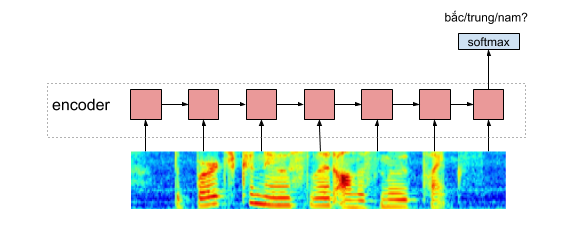
model


**Train**

Các bạn cần tải tập train và test, rồi để vào folder như trong code, sau đó chạy lệnh sau để build tập train và test. Dữ liệu sẽ lưu xuống thư mục được config và dùng để train model

>>python make_data.py

Sau khi tạo dữ liệu xong, các bạn cần chạy lệnh sau để huấn luyện model. Mình huấn luyện model cho gender, và accent riêng. Sau khoảng 600 epochs thì acc của gender trên tập validate là 96%, còn accent là 85%. Trên public leaderboard các bạn sẽ được khoảng 67.8%, và nằm trong top 10.

python lstm.py

#make_data.py

In [ ]:
import numpy as np
import librosa
import math
import re
import os
from multiprocessing import Pool
from keras.utils import to_categorical

gender_dict = {'female':0, 'male':1}
region_dict = {'north':0, 'central':1, 'south':2}

def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

def getfeature(fname):
    timeseries_length=128
    hop_length = 512
    data = np.zeros((timeseries_length, 33), dtype=np.float64)

    y, sr = librosa.load(fname)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)

    filelength = timeseries_length if mfcc.shape[1] >= timeseries_length else mfcc.shape[1]
    

    data[-filelength:, 0:13] = mfcc.T[0:timeseries_length, :]
    data[-filelength:, 13:14] = spectral_center.T[0:timeseries_length, :]
    data[-filelength:, 14:26] = chroma.T[0:timeseries_length, :]
    data[-filelength:, 26:33] = spectral_contrast.T[0:timeseries_length, :]

    return data

def processtrain(fname):
    data = getfeature(fname)
    gender, region = fname.split('/')[-2].split('_')
    print(fname)

    return data, gender, region

def processtest(fname):
    data = getfeature(fname)
    name = fname.split('/')[-1]
    print(fname)

    return data, name

def train():
    files = list(absoluteFilePaths('../data/voice_zaloai/train/'))
    p = Pool(40)    
    data = p.map(processtrain, files)
    X = [data[i][0] for i in range(len(data))]
    X = np.asarray(X)

    gender = [gender_dict[data[i][1]] for i in range(len(data))]
    gender = to_categorical(gender)

    region = [region_dict[data[i][2]] for i in range(len(data))]
    region = to_categorical(region)
    
    np.savez('../data/voice_zaloai/train', X=X, gender=gender, region=region)

def test():
    files = list(absoluteFilePaths('../data/voice_zaloai/public_test/'))
    p = Pool(40) 
    data = p.map(processtest, files)
    
    X = [data[i][0] for i in range(len(data))]
    X = np.asarray(X)
    
    name = [data[i][1] for i in range(len(data))]
    np.savez('../data/voice_zaloai/publictest', X=X, name=name)

if __name__=='__main__':
    train()
    test() 

#LSTM


In [ ]:
import numpy as np
from numpy.random import seed
seed(2018)
from tensorflow import set_random_seed
set_random_seed(2018)
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam,Adadelta,Nadam,Adamax,RMSprop
from sklearn.model_selection import train_test_split



def get_model(timeseries, nfeatures, nclass):
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=(timeseries, nfeatures)))
    model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
    model.add(Dense(units=nclass, activation='softmax'))

    return model

data = np.load('../data/voice_zaloai/train.npz')
X, gender, region = data['X'], data['gender'], data['region']
X_train, X_test, gender_train, gender_test, region_train, region_test = train_test_split(X, gender, region, test_size=0.2, random_state=2018)

publictest = np.load('../data/voice_zaloai/publictest.npz')
X_publictest, fname = publictest['X'], publictest['name']

print('train test: ', X_train.shape, X_test.shape)
print('public test: ', X_publictest.shape)

opt = RMSprop()
model = get_model(X.shape[1], X.shape[2], 3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

batch_size = 1024
nb_epochs = 10000

model.fit(X_train, region_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(X_test, region_test), verbose=2)

predicts = model.predict(X_publictest, batch_size=batch_size)
predicts = np.argmax(predicts, axis=1)

region_dict = {0:'north', 1:'central', 2:'south'}
gender_dict = {0:'female', 1:'male'}
for i in range(32):
    print(fname[i], '-->', region_dict[predicts[i]])

submit = pd.DataFrame.from_dict({'id':fname, 'accent':predicts}) 
submit.to_csv('submit.csv', index=False)